# Weight Map and Catalogue

In [1]:
# import libraries
import numpy as np
import sep
from scipy import ndimage

# setup for reading the image (not required to generate catalogue)
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

Filename: DESJ233551.8640-515217.7600_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      84   (228, 228)   float32   
  1  MSK           1 ImageHDU        76   (228, 228)   int32   
  2  WGT           1 ImageHDU        66   (228, 228)   float32   


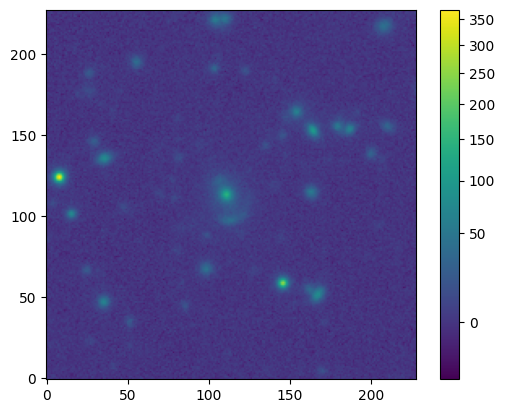

In [2]:
# import image data
data = fits.open("DESJ233551.8640-515217.7600_r.fits")
image_data = data[0].data # image_data in the 1st header
weight = data[2].data # weight map in the 3rd header
data.info()

# plot image data
from astropy.visualization import simple_norm
norm = simple_norm(image_data, 'sqrt') # generating the normalisation for plotting
plt.figure()
plt.imshow(image_data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

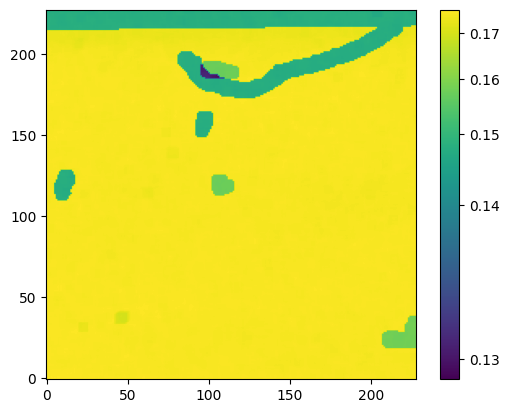

In [3]:
norm2 = simple_norm(weight, 'sqrt') # generating the normalisation for plotting
plt.figure()
plt.imshow(weight, norm=norm2, origin='lower', cmap='viridis')
plt.colorbar()

## Using DES Catalogue of Objects
Using WCS to map the RA and DEC onto the image.

The query used to obtain the catalogue is:  
**SELECT**  
&nbsp;&nbsp;&nbsp;&nbsp;RA,DEC  
**FROM** DR1_MAIN  
**WHERE**  
&nbsp;&nbsp;&nbsp;&nbsp;RA between *RA*-1/60 and *RA*+1/60 and  
&nbsp;&nbsp;&nbsp;&nbsp;DEC between *DEC*-1/60 and *DEC*+1/60

In [6]:
# Import catalogue of objects
des_data = fits.open("AGEL233552-515218_catalogue.fits")
des_data.info()
test = des_data[1].data

# Converting RA and DEC into pixel coordinates
from astropy.wcs import WCS # import WCS
wcs = WCS(header=data[0].header) # function according to image_data (what we are mapping onto)

ra_deg = test["RA"] # list of RA coords
dec_deg = test["DEC"] # list of DEC coords
x_pix, y_pix = wcs.all_world2pix(ra_deg, dec_deg, 0) # transformation from degrees to pixels


# Limiting to pixel in the size of image
x_pixel = x_pix[np.where(np.logical_and(np.logical_and(x_pix>=0, x_pix<=image_data.shape[0]), 
                                           np.logical_and(y_pix>=0, y_pix<=image_data.shape[1])))]
y_pixel = y_pix[np.where(np.logical_and(np.logical_and(x_pix>=0, x_pix<=image_data.shape[0]), 
                                           np.logical_and(y_pix>=0, y_pix<=image_data.shape[1])))]

Filename: AGEL233552-515218_catalogue.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     15   99R x 2C   [D, D]   


## Using SEP to generate catalogue

In [7]:
# Background subtraction
image_data_swap = image_data.byteswap().newbyteorder() # swap the order of bytes
bkg = sep.Background(image_data_swap) # background of image
data_sub = image_data - bkg # background subtracted image

# object detection
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)

48

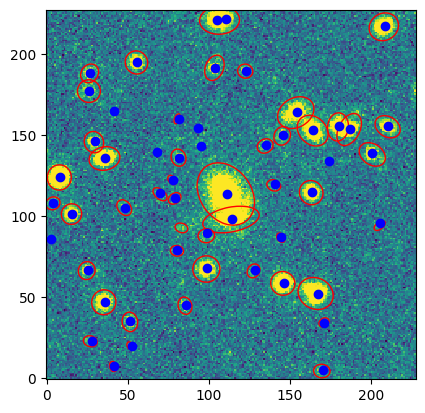

In [8]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
mean_sub, std_sub = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='viridis',
            vmin=mean_sub-std_sub, vmax=mean_sub+std_sub, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# plot SEP catalogue with the DES catalogue as a comparison to ensure DES catalogue transformed correctly
plt.plot(x_pixel, y_pixel, 'o', color='blue')

## Variance Matrix
For future reference:

var_matrix = ndimage.generic_filter(image_data, np.var, size=3)